<a href="https://colab.research.google.com/github/byteLm/rs/blob/main/clean_clouds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#######################################
#  Código Documentado: Detecção e Remoção de Nuvens em Imagens Multiespectrais
#  Autores: Luccas M. T. Freitas, Celso Augusto Guimarães Santos, Leonardo Vidal Batista
#  Versão: 2.0
#####
# Utilizado o DATASET: https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/
# Utilizado como classificado o Scene Classification (SCL) disponibilizado pelo projeto Sentinel-2.
# * SCL: Scene Classification
# * NDWI: Normalized_Difference_Water_Vegetation_Index
#####
# * Pixels considerados poluição:
#   * (255, 255, 255), (193, 193, 193), (100, 201, 255), (100, 50, 0), (0, 0, 0), (100, 51, 0),
#   * (255, 151, 255), (47, 47, 47)
#######################################

# NOTAS VERSÃO 2.0:
# * Código documentado
# * Aplicação SUBSTITUIÇÃO POR DATA PRÓXIMA (SUBSTITUIR POR DATA ANTERIOR ou DATA PROXIMA)
# * Aplicação SUBSTITUIÇÃO POR PIXEL PRÓXIMO (SUBSTITUIR POR PIXEL ANTERIOR ou PIXEL PROXIMO)
# * NDWI (Normalized Difference Water Vegetation Index) - POR QUADRIMESTRE e por BIMESTRE



## Conexão com o Google Drive (Arquivos)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Bibliotecas Utilizadas:

In [ ]:
!pip install rasterio


In [ ]:
import rasterio as TIFF
import random
from PIL import Image as img
import cv2
from matplotlib import pyplot as plt
import os
import datetime
import os
import shutil
import numpy as np
from datetime import datetime as dt

## **Images**

In [ ]:
def display_img(image_path):
    # Open the image
    with TIFF.open(image_path) as src:
        # Read the bands
        band1 = src.read(3)
        band2 = src.read(2)
        band3 = src.read(1)

    # Stack bands
    rgb = np.dstack((band1, band2, band3))

    # Normalize bands into 0.0 - 1.0 scale
    rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min())

    # Display the image
    plt.imshow(rgb_norm)


### O objeto 'Nuvens' irá conter todas as funções que serão utilizadas. As definições são dadas abaixo.

In [ ]:

path = "/content/drive/MyDrive/Seixas/original/SLC/"
list_years = [str(year) for year in range(1984, 2025)]

for year in list_years:
   for file in os.listdir(path + str(year)):
       if(file.find(year) != -1 and file.find("png") != -1 ):
           # Construct the destination path
           dest_path = f"/content/seixas/{year}/scl/"
           # Create the destination directory if it doesn't exist
           os.makedirs(dest_path, exist_ok=True)
           # Copy the file to the destination directory
           shutil.move(os.path.join(path, str(year), file), dest_path)


KeyboardInterrupt: 

In [ ]:

path = path = "/content/drive/MyDrive/Seixas/original/6B/"
list_years = [str(year) for year in range(1984, 2025)]

for year in list_years:
   for file in os.listdir(path + str(year)):
       if(file.find(year) != -1 and file.find("tif") != -1 ):
           # Construct the destination path
           dest_path = f"/content/seixas/{year}/6B/"
           # Create the destination directory if it doesn't exist
           os.makedirs(dest_path, exist_ok=True)
           # Copy the file to the destination directory
           shutil.copy(os.path.join(path, str(year), file), dest_path)




In [ ]:
with TIFF.open("/content/drive/MyDrive/Seixas/SCL/1984/seixas_19840610.png") as img :
        image = img.read()[0]
        print(image.shape)

(117, 45)


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


# Código atual


In [ ]:

class BCL:
    def __init__(self, img_dim, scl_path_i, path_6B_i, year_i, data_i, intern_reservoir, use_dec_tree):
          self.intern_reservoir = intern_reservoir
          self.width, self.height = img_dim
          self.scl_path = scl_path_i
          self.path_6B = path_6B_i
          self.year = year_i
          self.nuvem = [255]
          self.idx_class_cloud = 0
          # if int(year_i) >= 2013 and not use_dec_tree: # é landsat 8
          #   self.idx_class_cloud = 17
          # elif int(year_i) >= 2013 and use_dec_tree:
          #   self.idx_class_cloud = 17
          # else:
          #   self.idx_class_cloud = 13


          # arquivo que relaciona a data da imagem que foi utilizada e qual é a cor correspondente na mascara
          self.color_file = open(f"color_file_{data_i}.txt", "w")
          pass

    def death(self):
        del self

    def pxHasCloud(self, pixelValue):
        return pixelValue in self.nuvem

    # Função que carrega em memórias as imagens que serão corrigidas
    def getImageSCLandNDNWI(self, data, year):

        for imageSCL in os.listdir(self.scl_path):
            if(imageSCL.find(data)!=-1):
                with TIFF.open(self.scl_path+imageSCL) as img :
                    self.imgSCL = img.read()
                    self.sclMETA = img.meta

        for imageNDWI in os.listdir(self.path_6B):
            if(imageNDWI.find(data)!=-1):
                with TIFF.open(self.path_6B+imageNDWI) as img :
                    self.imgNDWI = img.read()
                    self.ndwiMETA=img.meta
                    print(self.ndwiMETA)
      # Essa imagem é grayscale, cada cor imagem que for usada será uma cor diferente
        # sempre que um pixel de uma imagem for utilizado, essa máscara será marcada na mesma localização com a cor da imagem
        self.mask = np.zeros((self.imgSCL.shape[1], self.imgSCL.shape[2]), dtype=np.uint8)

    # Os pixels que já estiverem 'limpos' serão mantidos
    # Aqueles que estão com nuvens ou sombras serão marcados em memória.
    def alreadyClear(self):

        # Cria uma matriz booleana onde True indica que o pixel está poluído
        cloud_mask = np.isin(self.imgSCL[self.idx_class_cloud], self.nuvem)

        # Cria uma máscara onde True indica que o pixel está limpo
        clear_mask = ~cloud_mask

        # Transfere os pixels limpos para o resultado
        self.resultadoIMGSCL[0][clear_mask] = self.imgSCL[self.idx_class_cloud][clear_mask]
        for i in range(6):
            self.resultadoIMGNDWI[i][clear_mask] = self.imgNDWI[i][clear_mask]
        self.mask[clear_mask] = [0]
        self.color_file.write("0 is the actual color of the image\n")

    # Função que carrega em memória todas as imagens do ano
    def getAllImagesYear(self, year, data):
        self.imagesSclOfTheYear = []
        for image in os.listdir(self.scl_path):
            if(image.find(data)!=-1):
                continue
            else:
                self.imagesSclOfTheYear.append(image)

    # Função responsável por receber uma data e
    def relativeTime(self, init_date):

        # Converte a data para o formato datetime
        data1 = dt.strptime(init_date, '%Y%m%d')

        self.relativeTimeList, self.pairImages = [], []

        for imagem in self.imagesSclOfTheYear:
            if imagem.endswith(".png"):
              if init_date in imagem:
                  continue

              # Obtém a data da imagem
              size_init_path = len(self.intern_reservoir + "_")
              date = image[size_init_path:size_init_path+8]

              print(f"Date = {date}")

              formated_date = dt.strptime(date, '%Y%m%d')

              # Calcula a distância entre as datas e salva na lista
              self.relativeTimeList.append(abs((formated_date - data1).days))
              self.pairImages.append(imagem)
        return self.pairImages

    # Nesta função é gerada a imagem
    def subPorDataProx(self, year, just_that=False):

        # Cada imagem será uma lista, em que o primeiro elemento é o nome da imagem
        # e os demais são os pixels que podem ser utilizados para a correção temporal
        self.elementos = [[] for _ in range(len(self.imagesSclOfTheYear))]

        # Essa imagem é grayscale, cada cor imagem que for usada será uma cor diferente
        # sempre que um pixel de uma imagem for utilizado, essa máscara será marcada na mesma localização com a cor da imagem
        self.mask = np.zeros((self.imgSCL.shape[1], self.imgSCL.shape[2], 3), dtype=np.uint8)

        # Pixels de valores altearios
        color = 5

        dict_color_image = {}

        # Para cada slot
        for i, _ in enumerate(self.elementos):

            # Índice de imagem mais próxima
            i_image_more_closer = self.relativeTimeList.index(min(self.relativeTimeList))
            path_image_more_close_scl = self.scl_path + self.pairImages[i_image_more_closer]


            # Filtro para obter a data da imagem
            size_init_path = len(self.intern_reservoir + "_")
            date = self.pairImages[i_image_more_closer][size_init_path:size_init_path+8]

            for i6b in os.listdir(self.path_6B):
                if(i6b.find(date)!=-1):
                    with TIFF.open(self.path_6B+i6b) as tiff:
                        image_more_close_6b = tiff.read()
                        break


            # A imagem mais próxima é carregada
            with TIFF.open(path_image_more_close_scl) as tiff:
                image_more_close_scl = tiff.read()
                array_image_more_close_scl = image_more_close_scl[0]


            # O primeiro elemento da lista é o nome da imagem
            self.elementos[i].append(self.pairImages[i_image_more_closer])
            self.relativeTimeList[i_image_more_closer] = 50000 # Aqui ela deixa de ser a mais próxima na próxima iteração

            # Onde na imagem é pixel limpo e nos resultados ainda é -1, é substituído o pixel poluído pelo limpo
            mask1 = np.logical_not(np.isin(array_image_more_close_scl, self.nuvem))
            mask2 = self.resultadoIMGSCL[0] == -1

            # se mask2 não tiver nenhum pixel -1, não há mais pixels para serem substituídos
            if not np.any(mask2):
                break

            self.resultadoIMGSCL[0][(mask1 & mask2)] = array_image_more_close_scl[(mask1 & mask2)]
            self.resultadoIMGNDWI[0][(mask1 & mask2)] = image_more_close_6b[0][(mask1 & mask2)]
            self.resultadoIMGNDWI[1][(mask1 & mask2)] = image_more_close_6b[1][(mask1 & mask2)]
            self.resultadoIMGNDWI[2][(mask1 & mask2)] = image_more_close_6b[2][(mask1 & mask2)]
            self.resultadoIMGNDWI[3][(mask1 & mask2)] = image_more_close_6b[3][(mask1 & mask2)]
            self.resultadoIMGNDWI[4][(mask1 & mask2)] = image_more_close_6b[4][(mask1 & mask2)]
            self.resultadoIMGNDWI[5][(mask1 & mask2)] = image_more_close_6b[5][(mask1 & mask2)]

            # Color[i] is like [255 255 255], so it is necessary to convert px format [255,255,255]
            if(color < 255):
                color += 5

            self.mask[mask1 & mask2] = [color]
            dict_color_image[str(color)] = self.pairImages[i_image_more_closer]




        if(just_that):
            # onde for -1, não foi possível substituir o pixel
            # então será atribuído o valor original da imagem
            self.resultadoIMGSCL[0][(self.resultadoIMGSCL[0] == -1)] = self.imgSCL[self.idx_class_cloud][(self.resultadoIMGSCL[0] == -1)]
            # self.resultadoIMGNDWI[:, (self.resultadoIMGSCL[0] == -1)] = self.imgNDWI[:, (self.resultadoIMGSCL[0] == -1)]

            self.mask[self.resultadoIMGSCL[0] == -1] = [0]

            dict_color_image[str([0])] = "could no be corrected"

        for key, value in dict_color_image.items():
            self.color_file.write(f"{key} is the color of {value}\n")

    def singleImageCorrection(self, data, year,  output_path, just_sp=False):

        # Obtém os objetos internos para serem corrigidos, a imagem SCL e a imagem NDWI
        self.getImageSCLandNDNWI(data, year)

         # os resultados são inicialmente arrays de -1
        self.resultadoIMGSCL = np.full((1, self.imgSCL.shape[1], self.imgSCL.shape[2]), -1, dtype=np.int16)
        self.resultadoIMGNDWI = np.full((self.imgNDWI.shape[0], self.imgNDWI.shape[1], self.imgNDWI.shape[2]), -1, dtype=np.int16)


        # # Salva os pixels que estão poluídos
        self.alreadyClear()
        self.getAllImagesYear(year, data)

        # Correção temporal
        self.relativeTime(data)
        self.subPorDataProx(year, just_sp)

        # # self.correcaoPorBorda(3, 3)
        self.resultadoIMGSCL = np.where(self.resultadoIMGSCL == -1, 0, self.resultadoIMGSCL)
        self.resultadoIMGNDWI = np.where(self.resultadoIMGNDWI == -1, 0, self.resultadoIMGNDWI)
        scl_output_path = os.path.join(output_path, "SCL")
        a6b_output_path = os.path.join(output_path, "6B")

        if not os.path.exists(scl_output_path):
            os.makedirs(scl_output_path)
        if not os.path.exists(a6b_output_path):
            os.makedirs(a6b_output_path)

        # Salvando novo arquivo com resultado e rasterio
        cv2.imwrite(scl_output_path+"/"+data+"_SCL.png", self.resultadoIMGSCL[0])
        with TIFF.open(a6b_output_path+"/"+data+"_6B.tif", 'w', **self.ndwiMETA) as dst:
            dst.write(self.resultadoIMGNDWI)






In [ ]:
list_years = [str(year) for year in range(1984, 2025)]
listReservPath = ["Seixas"]
initial_path = "/content/drive/MyDrive/Seixas/original/"
for internReservoir in listReservPath:

    print(f"Executando reservatório {internReservoir}.")

    for year in list_years:
        scl_path = initial_path + "/SCL/" + year + "/"
        path_6B = initial_path + "/6B/" + year + "/"

        for image in os.listdir(scl_path):
          if image.endswith(".png"):
            print(f"Executando o ano de {year}")

            # Greping img_size limits from sample.
            img_sample_path = (os.listdir(scl_path)[0])
            with TIFF.open(scl_path + img_sample_path) as tiff:
                image_tiff = tiff.read()
            size = image_tiff.shape[1], image_tiff.shape[2]
            print(image_tiff.shape)

            # obtenção da data
            size_init_path = len(internReservoir + "_")
            date = image[size_init_path:size_init_path+8]

            print(date)

            # Classe que será utilizada
            i = BCL(size, scl_path, path_6B, year, date, internReservoir, use_dec_tree = False)

            # Correção
            output_path = f"/content/drive/MyDrive/Seixas/Cleaned_with_QA/{year}/"
            i.singleImageCorrection(date, year, output_path, True)

            cv2.imwrite(output_path + f"mask_{image}.png", i.mask)
            i.death()

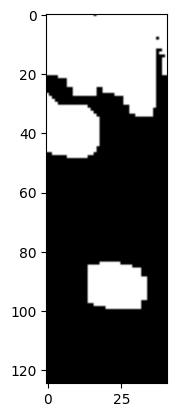

In [ ]:

name = "20150208"
brute_path = f'/content/drive/MyDrive/Seixas/6B/{name[:4]}/seixas_{name}.tif'
brute_scl = f'/content/drive/MyDrive/Seixas/SCL/{name[:4]}/seixas_{name}.png'

# display_img(brute_path)
display_img(brute_scl)




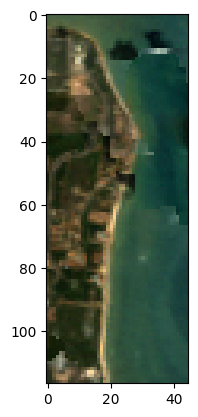

In [ ]:
cleaned_6b = f'/content/drive/MyDrive/Seixas/Cleaned_with_QA/{name[:4]}/6B/{name}_6B.tif'
cleaned_scl = f'/content/drive/MyDrive/Seixas/Cleaned_with_QA/{name[:4]}/SCL/{name}_SCL.png'
display_img(cleaned_6b)
# plt.imshow(cv2.imread(cleaned_scl))